In [47]:
import cv2
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageOps

import gdown as gdown
import zipfile

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

In [2]:
from Models.Models import *

In [10]:
PATH = os.getcwd()
charToASCII = {'0': 48, '1': 49, '2': 50, '3': 51, '4': 52, '5': 53, '6': 54, '7': 55, '8': 56, '9': 57, 'A': 65, 'B': 66, 'C': 67, 'D': 68, 'E': 69, 'F': 70, 'G': 71, 'H': 72, 'I': 73, 'J': 74, 'K': 75, 'L': 76, 'M': 77, 'N': 78, 'O': 79, 'P': 80, 'Q': 81, 'R': 82, 'S': 83, 'T': 84, 'U': 85, 'V': 86, 'W': 87, 'X': 88, 'Y': 89, 'Z': 90, 'a': 97, 'b': 98, 'c': 99, 'd': 100, 'e': 101, 'f': 102, 'g': 103, 'h': 104, 'i': 105, 'j': 106, 'k': 107, 'l': 108, 'm': 109, 'n': 110, 'o': 111, 'p': 112, 'q': 113, 'r': 114, 's': 115, 't': 116, 'u': 117, 'v': 118, 'w': 119, 'x': 120, 'y': 121, 'z': 122}
ASCIIToChar = {48: '0', 49: '1', 50: '2', 51: '3', 52: '4', 53: '5', 54: '6', 55: '7', 56: '8', 57: '9', 65: 'A', 66: 'B', 67: 'C', 68: 'D', 69: 'E', 70: 'F', 71: 'G', 72: 'H', 73: 'I', 74: 'J', 75: 'K', 76: 'L', 77: 'M', 78: 'N', 79: 'O', 80: 'P', 81: 'Q', 82: 'R', 83: 'S', 84: 'T', 85: 'U', 86: 'V', 87: 'W', 88: 'X', 89: 'Y', 90: 'Z', 97: 'a', 98: 'b', 99: 'c', 100: 'd', 101: 'e', 102: 'f', 103: 'g', 104: 'h', 105: 'i', 106: 'j', 107: 'k', 108: 'l', 109: 'm', 110: 'n', 111: 'o', 112: 'p', 113: 'q', 114: 'r', 115: 's', 116: 't', 117: 'u', 118: 'v', 119: 'w', 120: 'x', 121: 'y', 122: 'z'}
classToChar = []
for key in charToASCII.keys():
    classToChar.append(key)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# Descarga los modelos entrenados
url =  'https://drive.google.com/uc?id=1PGKJ4GU9yI1JVVddAtvuyhyPfL719BUG&export=download'
output = 'Models/models.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile(PATH + "/Models/models.zip","r") as zip_ref:
    zip_ref.extractall(PATH + "/Models/")

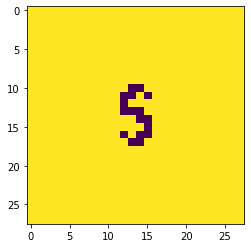

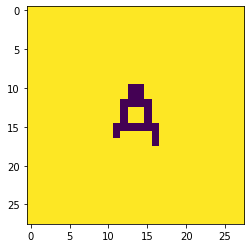

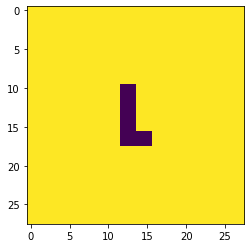

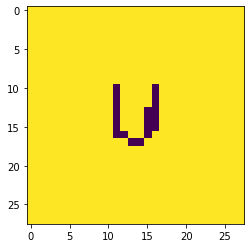

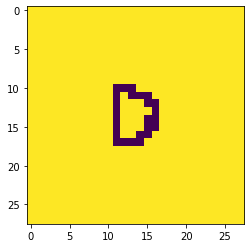

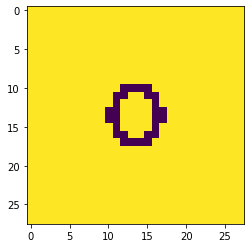

6
<class 'numpy.ndarray'>
(28, 28)


In [106]:
#Obtener images = lista de np arrays que entran al modelo
img = cv2.imread(PATH + '/out.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
mask = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)
conts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
boxes = []
for cntr in conts:
    x,y,w,h = cv2.boundingRect(cntr)
    boxes.append((x,y,w,h))

boxes = sorted(boxes, key=lambda x: (x))

images = []
for e, i in enumerate(boxes):
    x = i[0]
    y = i[1]
    w = i[2]
    h = i[3]
    cropped = thresh[y:y+h, x:x+w]
    cropped = 255 - cropped
    height = cropped.shape[0]
    width = cropped.shape[1]
    val = 150
    if (height > width):
        diff = height - width
        padding = cv2.copyMakeBorder(cropped,val,val,val+int(diff/2),val+int(diff/2),cv2.BORDER_CONSTANT,value=[255,255,255])
    elif (height == width):
        padding = cv2.copyMakeBorder(cropped,val,val,val,val,cv2.BORDER_CONSTANT,value=[255,255,255])
    else:
        diff = width - height
        padding = cv2.copyMakeBorder(cropped,val+int(diff/2),val+int(diff/2),val,val,cv2.BORDER_CONSTANT,value=[255,255,255])
    resized = cv2.resize(padding, (28, 28))
    for ii in range(resized.shape[0]):
        for jj in range(resized.shape[1]):
            if resized[ii][jj] < 1.0:
                resized[ii][jj] = 0.0
            else:
                resized[ii][jj] = 255.0
    images.append(resized.astype('float32'))    
    if e < 6:
        plt.imshow(resized)
        plt.show()
    
print(len(images))
print(type(images[0]))
print(images[0].shape)

In [61]:
# Carga el modelo y lo envia a device
model = torch.load(PATH + '/Models/Lenet5.pt')
model = model.to(device)
model.eval()

Lenet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=84, out_features=62, bias=True)
  )
)

In [70]:
mapIndex = {}
i = 0
for key in ASCIIToChar.keys():
    mapIndex[key] = i
    i += 1
PATH_DATASET = "E:\\Handwritten Dataset\\by_class\\" #Path to dataset
chars = []
class_id = 104
i = 0
PATH_CLASS = PATH_DATASET + str(hex(class_id))[2:] + "\\train_" + str(hex(class_id))[2:] + "\\"
for file in listdir(PATH_CLASS):
    img = Image.open(PATH_CLASS + file)
    img = ImageOps.grayscale(img)
    img = img.resize((28, 28))
    images.append(np.array(img))
    i += 1
    if i == 10:
        break


In [54]:
print()

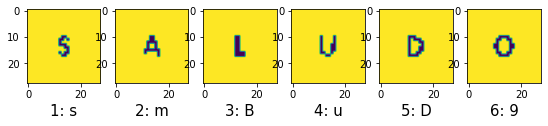

In [107]:
#Testea
transformToTensor = transforms.ToTensor()
imageTensors = [transformToTensor(np.array(img)) for img in images]
imageBatch = torch.utils.data.DataLoader(dataset=imageTensors, batch_size=64, shuffle=False)

batch = 0
for imgBatch in imageBatch:
    imgBatch = imgBatch.to(device)
    labelBatchPred = model(imgBatch)
    
    labelBatchPred = labelBatchPred.to('cpu')
    imgBatch = imgBatch.to('cpu')
    #print(labelBatchPred[0])
    _, predBatch = torch.max(labelBatchPred, 1)
    
    group = 0
    n = len(imgBatch)
    ok = 1
    while(group < 4 and ok):
        plt.figure(figsize = (25, 10))
        r, c = 1, 16
        for i in range(16):
            plt.subplot(r, c, i+1)
            plt.imshow(imgBatch[16*group + i].permute(1, 2, 0))
            #plt.xlabel(str(64*batch + 16*group + i + 1) + ": " + classToChar[predBatch[16*group + i].item()] + " (" + classToChar[np.argmax(y_data[16*group + i])] + ")", fontsize = 15)
            plt.xlabel(str(64*batch + 16*group + i + 1) + ": " + classToChar[predBatch[16*group + i].item()], fontsize = 15)
            if 16*group + i + 1 == n:
                ok = 0
                break
        plt.show()
        print("")
        group += 1
    batch += 1